In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from importlib import reload
from mppi import InputFiles as I, Calculators as C, Datasets as D

In [2]:
omp = 1
mpi_run = 'mpirun -np 16'

Choose the source and the  run_dir on the basis of the number of k-points and shift

In [3]:
#source = 'nscf/bnds_40-kpoints_4.save'
#source = 'nscf/bnds_40-kpoints_8.save'
#source = 'nscf/bnds_40-kpoints_12.save'
#source = 'nscf/bnds_40-kpoints_8-shift_1.save'
#source = 'nscf/bnds_40-kpoints_10-shift_1.save'
source = 'nscf/bnds_40-kpoints_100-sampling_random.save'
#source = 'nscf/bnds_40-sampling_gamma.save'
#source = 'nscf/bnds_40-sampling_gamma_and_shifted_points.save'
#source = 'nscf/bnds_40-kpoints_50-sampling_random-5em3-close-gamma.save'

#run_dir = 'rt_gamma'
#run_dir = 'rt_gamma_no.com'
#run_dir = 'rt_gamma-and-close'
#run_dir = 'rt_gamma-and-close_no-com'
run_dir = 'rt_k100random_width100_no-com'

## Construction of the FixSymm folder

The first step of this procedure is represented by the construction of the Yambo base folder with the SAVE directory. 

We use the tools of Dataset to build the SAVE folder and choose various folder as source path.

In [4]:
y_save = D.Dataset(label='y_save',run_dir=run_dir,pre_processing='yambo')

In [5]:
y_save.pre_processing_function(source_dir=source)

Create folder rt_k100random_width100_no-com
execute :  cd nscf/bnds_40-kpoints_100-sampling_random.save;p2y -a 2
execute :  cp -r nscf/bnds_40-kpoints_100-sampling_random.save/SAVE rt_k100random_width100_no-com
execute :  cd rt_k100random_width100_no-com;OMP_NUM_THREADS=1 yambo


In [6]:
ypp_input = I.YppIn('ypp -y',folder=y_save.run_dir)

input = ypp_input.getInput()
input['Efield1'] = [1.0,0.0,0.0]
input['Efield2'] = [0.0,1.0,0.0]
print(input)
ypp_input.write(y_save.run_dir+'/ypp.in')

execute :  cd rt_k100random_width100_no-com; ypp -y -F ypp.in
fixsyms
Btheta = 0.000000e+00 deg
Bpsi = 0.000000e+00 deg
BField = 0.000000e+00 T
% Efield1
 1.0 | 0.0 | 0.0 |   
%
% Efield2
 0.0 | 1.0 | 0.0 |   
%

execute :  cd rt_k100random_width100_no-com; ypp -y -F ypp.in


Build the FixSymm folder and run yambo_rt (without argument) to build the r_setup

In [7]:
string = 'cd %s; ypp -F ypp.in'%y_save.run_dir
print(string)
os.system(string)

cd rt_k100random_width100_no-com; ypp -F ypp.in


0

In [8]:
fixSymmPath = y_save.run_dir+'/FixSymm'
string = 'cd %s; yambo_rt'%fixSymmPath
print(string)
os.system(string)

cd rt_k100random_width100_no-com/FixSymm; yambo_rt


0

## Real Time Analysis

Define the code that will run yambo_rt and the dataset for the rt computations. Note that no pre_processing is nedded for this dataset since the FixSymm folder that contains the rt SAVE is already built.

We have performed some tests to set the parameters of the run, in particular : 

* the damping is needed, without damping the the dN does not follows the shape of the fluence of the field but show a gaussian like behavior.

* A convergence test has been performed on the number of RTBands, the actual choice is [5,10], we have checked that increasing this interval produces only a small change in the dN at the end of the NETime

In [4]:
code = C.YamboCalculator(omp=omp,mpi_run=mpi_run,executable='yambo_rt',suffix='carriers',skip=True)

Initialize a Yambo calculator with command OMP_NUM_THREADS=1 mpirun -np 16 yambo_rt
Suffix for post_processing :  carriers


In [5]:
run_dir_rt = os.path.join(run_dir,'FixSymm')
print(run_dir_rt)

rt_k100random_width100_no-com/FixSymm


In [6]:
yambo_rt = D.Dataset(label='yambo_rt',run_dir=run_dir_rt)

Change name to the ns.kb_pp_pwscf database to remove the non local contribution

In [12]:
db = 'ns.kb_pp_pwscf'
src = os.path.join(yambo_rt.run_dir,'SAVE',db)
dst = os.path.join(yambo_rt.run_dir,'SAVE',db+'_hide')
string = 'mv %s %s'%(src,dst)
print(string)
os.system(string)

mv rt_k100random_width100_no-com/FixSymm/SAVE/ns.kb_pp_pwscf rt_k100random_width100_no-com/FixSymm/SAVE/ns.kb_pp_pwscf_hide


0

We add various runs to the dataset. First of all we define the basic elements of the input file

In [7]:
rt_input = I.YamboIn('yambo_rt -n p -v ip -V qp',folder=yambo_rt.run_dir)

time_step = 10 #as
field_int = 1000.0 #kWLm2
field_width = 100 #fs
sim_time = 6*field_width
rt_bands = [5,10]

rt_parameters = {
     'Field1_Int'   : [field_int,'kWLm2'],
     'Field1_Width' : [field_width,'fs'],
     'Field1_kind'  : 'QSSIN',
     'RTstep'       : [time_step,'as'],
     'NETime'       : [sim_time,'fs'],
     'RTBands'      : rt_bands,
     'IOtime'       : [[1.0,5.0,1.0],'fs'], # Carriers - GF - output
     'GfnQP_Wv'     : [0.05,0.00,0.00],     # Constant damping valence
     'GfnQP_Wc'     : [0.05,0.00,0.00],     # Constant damping conduction
     'GfnQP_E'      : [1.00, 1.00, 1.00],   # Scissor
     'RT_CPU'       : "%s.1.1.1"%mpi_run.lstrip('mpirun -np ')
}

for k,v in rt_parameters.items():
    rt_input[k] = v

In [14]:
#print(rt_input)

In [8]:
# circular polarization spanning a given frequencies range
freq_range = [1.25,1.35,1.45,1.55,1.65,1.75,1.85]
#freq_range =  [1.55]
for f in freq_range:
    pars = { 'Field1_Freq'  : [[f,f],'eV'],
             'Field1_pol'   : 'circular',
             # the two fields reproduce the field used for FixSymm
             'Field1_Dir'   : [1.0,0.0,0.0],
             'Field1_Dir_circ'   : [0.0,1.0,0.0]
    }
    for k,v in pars.items():
        rt_input[k] = v
    idd = {'pol' : 'circular','freq' : f}
    yambo_rt.append_run(id=idd,calculator=code,input=rt_input)

In [9]:
# linear polarization with freq = 1.55 eV
freq = 1.55
pars = {
     'Field1_Freq'  : [[freq,freq],'eV'],
     'Field1_pol'   : 'linear',
     'Field1_Dir'   : [1.0,0.0,0.0]
}
for k,v in pars.items():
    rt_input[k] = v
idd = {'pol' : 'linear','freq' : freq}
yambo_rt.append_run(id=idd,calculator=code,input=rt_input)

In [10]:
# circular polarization (reversed) with freq = 1.55 eV
freq = 1.55
pars = {
     'Field1_Freq'  : [[freq,freq],'eV'],
     'Field1_pol'   : 'circular',
     'Field1_Dir'   : [0.0,1.0,0.0],
     'Field1_Dir_circ'   : [1.0,0.0,0.0]
}
for k,v in pars.items():
    rt_input[k] = v
idd = {'pol' : 'reversed_circular','freq' : freq}
yambo_rt.append_run(id=idd,calculator=code,input=rt_input)

In [82]:
# circular polarization (rotated y-> z) with freq = 1.55 eV
freq = 1.55
pars = {
     'Field1_Freq'  : [[freq,freq],'eV'],
     'Field1_pol'   : 'circular',
     'Field1_Dir'   : [1.0,0.0,0.0],
     'Field1_Dir_circ'   : [0.0,0.0,1.0]
}
for k,v in pars.items():
    rt_input[k] = v
idd = {'pol' : 'rotated_circular','freq' : freq}
yambo_rt.append_run(id=idd,calculator=code,input=rt_input)

In [28]:
#print(yambo_rt.runs[0])

In [9]:
yambo_rt.run()

skip the computation for : freq_1.25-pol_circular.in
parse file : rt_k100random_width100_no-com/FixSymm/freq_1.25-pol_circular/o-freq_1.25-pol_circular.carriers
skip the computation for : freq_1.35-pol_circular.in
parse file : rt_k100random_width100_no-com/FixSymm/freq_1.35-pol_circular/o-freq_1.35-pol_circular.carriers
skip the computation for : freq_1.45-pol_circular.in
parse file : rt_k100random_width100_no-com/FixSymm/freq_1.45-pol_circular/o-freq_1.45-pol_circular.carriers
skip the computation for : freq_1.55-pol_circular.in
parse file : rt_k100random_width100_no-com/FixSymm/freq_1.55-pol_circular/o-freq_1.55-pol_circular.carriers
skip the computation for : freq_1.65-pol_circular.in
parse file : rt_k100random_width100_no-com/FixSymm/freq_1.65-pol_circular/o-freq_1.65-pol_circular.carriers
skip the computation for : freq_1.75-pol_circular.in
parse file : rt_k100random_width100_no-com/FixSymm/freq_1.75-pol_circular/o-freq_1.75-pol_circular.carriers
skip the computation for : freq_1.

In [10]:
yambo_rt.ids

[{'freq': 1.25, 'pol': 'circular'},
 {'freq': 1.35, 'pol': 'circular'},
 {'freq': 1.45, 'pol': 'circular'},
 {'freq': 1.55, 'pol': 'circular'},
 {'freq': 1.65, 'pol': 'circular'},
 {'freq': 1.75, 'pol': 'circular'},
 {'freq': 1.85, 'pol': 'circular'}]

In [11]:
res = yambo_rt.results[0]

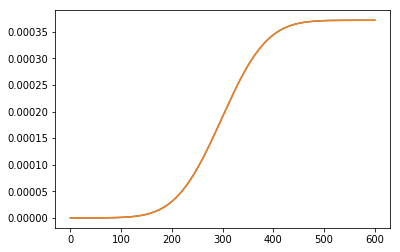

In [12]:
plt.plot(res.time,res.dN_hole)
plt.plot(res.time,res.dN_elec)

We plot the dN_e at the last simulation time in function of the probe frequency

(0, 0.005)

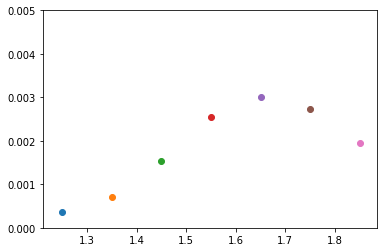

In [13]:
for ind,f in enumerate(freq_range):
    res = yambo_rt.results[ind]
    plt.scatter(f,res.dN_elec[-1])
plt.ylim((0,5e-3))

Plot the time dependence of the z component of the magnetization for each pump

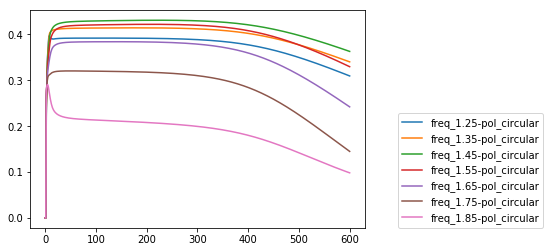

In [14]:
for radical in yambo_rt.names:
    mgn_file = os.path.join(run_dir_rt,radical,'o-'+radical+'.spin_magnetization')
    mgn = C.dict_parser(mgn_file)
    plt.plot(mgn['T'],mgn['Mc_z'],label = radical)
plt.legend(loc=(1.1,0.))
plt.show()

In [28]:
radical = yambo_rt.names[5]
print(radical)
mgn_file = os.path.join(run_dir_rt,radical,'o-'+radical+'.spin_magnetization')
mgn = C.dict_parser(mgn_file)

freq_1.75-pol_circular


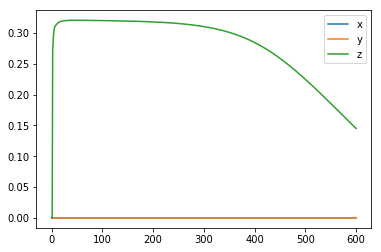

In [29]:
plt.plot(mgn['T'],mgn['Mc_x'],label = 'x')
plt.plot(mgn['T'],mgn['Mc_y'],label = 'y')
plt.plot(mgn['T'],mgn['Mc_z'],label = 'z')
plt.legend()

In [30]:
final_mgn = np.array([mgn['Mc_x'][-1],mgn['Mc_y'][-1],mgn['Mc_z'][-1]])
print(final_mgn)
print(mgn['Mc_z'][-1]*100)
100.*np.linalg.norm(final_mgn)

[4.28194113e-07 2.26145312e-06 1.45017564e-01]
14.50175643


14.501756431826509

The time dependence of the spin polarization is strange...check!!!!

## ypp post-processing for the rt bands and occupations

In [57]:
code = C.YamboCalculator(omp=1,mpi_run='mpirun -np 8',executable='ypp_rt',suffix='YPP-RT_occ_bands_iT1',skip=True)

Initialize a Yambo calculator with command OMP_NUM_THREADS=1 mpirun -np 8 ypp_rt
Suffix for post_processing :  YPP-RT_occupations_DATA


In [58]:
ypp_nob = D.Dataset(label='ypp_nob',run_dir=run_dir_rt)

In [59]:
ypp_input = I.YppIn('ypp_rt -n o b -V qp',folder=ypp_nob.run_dir)

delete rt_k100random_width100_no-com/FixSymm/ypp.in
execute :  cd rt_k100random_width100_no-com/FixSymm; ypp_rt -n o b -V qp -F ypp.in


In [60]:
# The random sampling is performed in a spherical region of diameter 0.1 around Gamma
# in alat
G = [0.,0.,0.]
X_dir = [0.1,0.,0.]
L_dir = [0.05,0.05,0.05] # in the direction of L but inside the sampled sphere
#W = [1.0,0.5,0.]
path = [L_dir,G,X_dir]

#band_range = [5,10]
bands_step = 50
time_step = 100 #fs

In [61]:
np.sqrt(3*0.05**2)

0.08660254037844388

In [62]:
input = ypp_input.getInput()
input['BANDS_steps'] = bands_step
#input['BANDS_bands'] = band_range
input['BANDS_kpts'] = path
input['cooIn'] = 'alat'
input['cooOut'] = 'alat'
input['TimeStep'] = [time_step,'fs']
input['TimeRange'] = [[0.,sim_time],'fs']

print(input)

RealTime
RToccupations
RTfitbands
OutputAlat = 10.677000 
cooOut =     'alat'
NelFac = 1.000000 
% TimeRange
 0.0 | 600 |  fs 
%
TimeStep = 100 fs
INTERP_mode =       'NN'
% INTERP_Grid
 -1 | -1 | -1 |   
%
% BANDS_kpts
0.05 | 0.05 | 0.05 |  
0.0 | 0.0 | 0.0 |  
0.1 | 0.0 | 0.0 |  
%
BANDS_steps = 50 
cooIn =     'alat'
CIRCUIT_E_DB_path =     'none'
INTERP_Shell_Fac = 20.000000 



In [63]:
yambo_rt.names

['freq_1.25-pol_circular',
 'freq_1.35-pol_circular',
 'freq_1.45-pol_circular',
 'freq_1.55-pol_circular',
 'freq_1.65-pol_circular',
 'freq_1.75-pol_circular',
 'freq_1.85-pol_circular']

In [64]:
for name in ['freq_1.55-pol_circular']: 
    idd = 'ypp_'+name
    ypp_nob.append_run(id=idd,input=ypp_input,calculator=code,jobname=name)

In [65]:
ypp_nob.run()

execute :  cd rt_k100random_width100_no-com/FixSymm; ypp_rt -n o b -V qp -F ypp_freq_1.55-pol_circular.in
execute : cd rt_k100random_width100_no-com/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 8 ypp_rt -F ypp_freq_1.55-pol_circular.in -J freq_1.55-pol_circular -C ypp_freq_1.55-pol_circular
file :  rt_k100random_width100_no-com/FixSymm/ypp_freq_1.55-pol_circular/o-freq_1.55-pol_circular.YPP-RT_occupations_DATA  not found. Parsing not performed


## ypp post-processing for the rt analysis

Perform the ypp -n o e post-processing using the rt results as input

In [27]:
code = C.YamboCalculator(omp=1,mpi_run='mpirun -np 1',executable='ypp_rt',suffix='YPP-RT_occupations_DATA',skip=True)

Initialize a Yambo calculator with command OMP_NUM_THREADS=1 mpirun -np 1 ypp_rt
Suffix for post_processing :  YPP-RT_occupations_DATA


In [28]:
ypp_noe = D.Dataset(label='ypp_noe',run_dir=run_dir_rt)

In [29]:
ypp_input = I.YppIn('ypp_rt -n o e -V qp',folder=ypp_noe.run_dir)

execute :  cd rt_gamma-and-close_no-com/FixSymm; ypp_rt -n o e -V qp -F ypp.in


In [30]:
input = ypp_input.getInput()
input['QPkrange'][0][3:5] = rt_bands
input['TimeStep'][0] = 100 #20
print(input)

RealTime
RToccupations
TimeStep = 100 fs
% QPerange
 1 | 7 | 0.0 | -1.000000 |   
%
% QPkrange
 1 | 7 | 1 | 5 | 10 |   
%
% TimeRange
 -1.000000 | -1.000000 |  fs 
%



Add the run the dataset. The names of the yambo_rt are given as jobname to the post-processing

In [31]:
for name in yambo_rt.names: 
    idd = 'ypp_'+name
    ypp_noe.append_run(id=idd,input=ypp_input,calculator=code,jobname=name)

In [32]:
ypp_noe.run()

execute :  cd rt_gamma-and-close_no-com/FixSymm; ypp_rt -n o e -V qp -F ypp_freq_1.55-pol_circular.in
execute : cd rt_gamma-and-close_no-com/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 1 ypp_rt -F ypp_freq_1.55-pol_circular.in -J freq_1.55-pol_circular -C ypp_freq_1.55-pol_circular
parse file : rt_gamma-and-close_no-com/FixSymm/ypp_freq_1.55-pol_circular/o-freq_1.55-pol_circular.YPP-RT_occupations_DATA
execute :  cd rt_gamma-and-close_no-com/FixSymm; ypp_rt -n o e -V qp -F ypp_freq_1.55-pol_linear.in
execute : cd rt_gamma-and-close_no-com/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 1 ypp_rt -F ypp_freq_1.55-pol_linear.in -J freq_1.55-pol_linear -C ypp_freq_1.55-pol_linear
parse file : rt_gamma-and-close_no-com/FixSymm/ypp_freq_1.55-pol_linear/o-freq_1.55-pol_linear.YPP-RT_occupations_DATA
execute :  cd rt_gamma-and-close_no-com/FixSymm; ypp_rt -n o e -V qp -F ypp_freq_1.55-pol_reversed_circular.in
execute : cd rt_gamma-and-close_no-com/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 1 ypp_rt -F ypp_freq_

In [33]:
ypp_noe.ids

['ypp_freq_1.55-pol_circular',
 'ypp_freq_1.55-pol_linear',
 'ypp_freq_1.55-pol_reversed_circular']

Use the output file for showing the neq occupations

In [32]:
res = ypp_noe.results[0].__dict__
res.keys()

dict_keys(['E', '240.000', '40.0000', '140.000'])

In [76]:
last_time = '240.000'

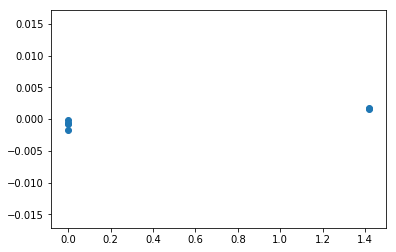

In [77]:
plt.scatter(res['E'],res[last_time])
#plt.ylim(-5e-3,5e-3)